This code is taken from
https://dfdazac.github.io/06-neural-networks-numpy.html

In [110]:
import numpy as np
np.random.seed(0)
from fractions import Fraction
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
def FloatToFrac(a):
    s = a.shape
    if len(s)==1:
        a = [Fraction(x) for x in a]
    else:
        a = [[Fraction(x) for x in row] for row in a]
    return np.array(a).reshape(s)

def FracToFloat(a):
    s = a.shape
    if len(s)==1:
        a = [float(x) for x in a]
    else:
        a = [[float(x) for x in row] for row in a]
    return np.array(a).reshape(s)

In [112]:

class Linear:
    """ A linear layer that performs the operation
    W X + b
    Args:
        - n_inputs (int): number of inputs
        - n_outputs (int): number of outputs
    """
    def __init__(self, n_inputs, n_outputs):
        self.W = FloatToFrac(np.random.standard_normal((n_outputs, n_inputs)) * np.sqrt(2/n_inputs))
        self.b = FloatToFrac(np.zeros((n_outputs, 1)))
        self.dW = None
        self.db = None
        self.A_prev = None
        self.Zl = None

    def __call__(self, X, cache=False):
        """ Performs a forward pass on the layer given X.
        Args:
            - X (n_inputs, n): input array
            - cache (bool): whether or not to save intermediate
                values. Used during backpropagation.
        Returns: the result of the operation of the layer on X.
        """
        Zl = self.W @ X + self.b
        if cache:
            self.A_prev = X.copy()
            self.Zl = Zl.copy()
        return Zl

In [113]:
def relu(X):
    """ ReLU activation function """
    return np.where(X > 0, X, Fraction(0))

def d_relu(X):
    """ Derivative of the ReLU activation function """
    return np.where(X > 0, Fraction(1), Fraction(0))

In [114]:
def one_hot_convert(t, n_classes):
    """ Convert arrays of integer labels to one-hot encoded vectors.
    Args:
        - t (n,): array containing n labels
        - n_classes (int): the number of possible classes
    Returns: (n_classes, n) binary array containing one-hot
        vectors in its columns.
    """
    s = t.shape
    t = [int(x) for x in  t]
    t = np.array(t).reshape(s)
    if np.min(t) < 0 or np.max(t) >= n_classes:
        raise ValueError("Elements in array must be in the interval [0, {:d})".format(n_classes))
    T = np.zeros((n_classes, len(t)), dtype=int)
    T[t, np.arange(len(t))] = 1
    return FloatToFrac(T)

In [115]:
class NNClassifier:
    """ A neural network classifier.
    Args:
        - units (iterable): contains the number of units (int)
            for each layer, from the input layer up to the
            output layer.
    """
    def __init__(self, units):
        self.units = units
        self.n_classes = units[-1]
        self.layers = []
        for i in range(1, len(units)):
            self.layers.append(Linear(units[i - 1], units[i]))
        self.dZL = None

    def forward(self, X, cache=False):
        A_prev = X
        for layer in self.layers:
            Zl = FloatToFrac(layer(A_prev, cache))
            A_prev = relu(Zl)

        return Zl

    def _log_normalizer(self, ZL):
        ZL = FracToFloat(ZL)
        max_ZL = np.max(ZL, axis=0, keepdims=True)
        log_Z = max_ZL + np.log(np.sum(np.exp(ZL - max_ZL), axis=0, keepdims=True))
        return FloatToFrac(log_Z)

    def loss(self, X, t):
        ZL = self.forward(X, cache=True)
        log_Z = self._log_normalizer(ZL)
        log_probs = ZL - log_Z

        T = one_hot_convert(t, self.n_classes)
        Z = np.exp(FracToFloat(log_Z))
        self.dZL = np.exp(FracToFloat(ZL))/Z - T

        return Fraction(-np.mean(log_probs[T == 1]))

    def forward_probs(self, X):
        ZL = self.forward(X)
        log_Z = self._log_normalizer(ZL)
        log_probs = ZL - log_Z
        return np.exp(FracToFloat(log_probs))

    def backward(self):
        # Number of samples in mini-batch
        n = Fraction(self.dZL.shape[1])
        for i, layer in enumerate(reversed(self.layers)):
            if i == 0:
                dZl = self.dZL
            else:
                dZl = d_relu(layer.Zl) * dAl
            layer.dW = 1/n * (dZl @ layer.A_prev.T)
            layer.db = np.mean(dZl, axis=1, keepdims=True)
            dAl = layer.W.T @ dZl

In [116]:
class SGD:
    """ Stochastic Gradient Descent optimizer.
    Args:
        - model (NNClassifier): model with parameters to optimize
        - lr (float): learning rate
    """
    def __init__(self, model, lr):
        self.lr = lr
        self.model = model

    def step(self):
        for layer in self.model.layers:
            layer.W = layer.W - self.lr * layer.dW
            layer.b = layer.b - self.lr * layer.db

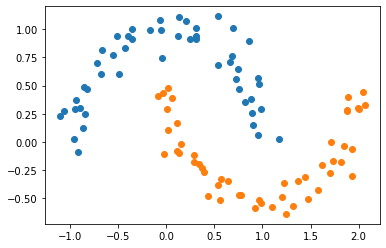

In [117]:
from sklearn.datasets import make_moons

X, Y = make_moons(noise=0.1)
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1]);

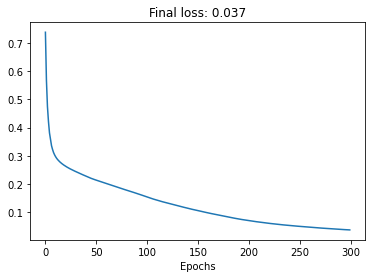

In [118]:
model = NNClassifier([2, 10, 2])
optimizer = SGD(model, lr=Fraction(0.5))

n_epochs = 300
loss_history = np.zeros(n_epochs)

for epoch in range(n_epochs):
    # Forward pass
    loss_history[epoch] = model.loss(FloatToFrac(X.T), FloatToFrac(Y))
    # Backward pass
    model.backward()
    # Parameter updates
    optimizer.step()

plt.plot(FracToFloat(loss_history))
plt.title('Final loss: {:.3f}'.format(np.min(FracToFloat(loss_history))))
plt.xlabel('Epochs');

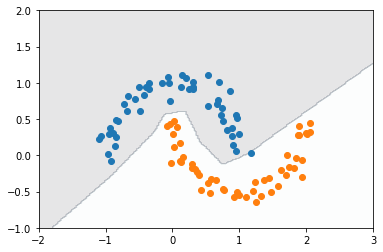

In [119]:
# Create a grid
N = 200
x1 = np.linspace(-2, 3, N)
x2 = np.linspace(-1, 2, N)
X1, X2 = np.meshgrid(x1, x2)
X_flat = np.column_stack((X1.flatten(), X2.flatten()))

# Evaluate model on grid
Y_pred = model.forward_probs(X_flat.T)[0, :].reshape(X1.shape) < 0.5

plt.contourf(X1, X2, Y_pred, cmap='bone', alpha=0.1)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1])
plt.scatter(X[Y == 1, 0], X[Y == 1, 1]);